In [ ]:
import numpy as np

df1 = np.load("handsignX.npy")
df2 = np.load("handsigny.npy")
print(df1.shape)
print(df2.shape)

In [ ]:
processed_df1 = np.zeros_like(df1)

In [ ]:
for i in range(df1.shape[0]):
    image = df1[i].reshape((20, 20)).T 

    #normalize the image data to the range [0, 255]
    image = (image - image.min()) / (image.max() - image.min()) * 255
    image = image.astype(np.uint8)

    #flatten the image to its original shape
    processed_df1[i] = image.flatten()

In [ ]:
df = np.concatenate((df2,processed_df1), axis=1)
np.savetxt('handsign.csv', df, delimiter=',', fmt='%d') 

A Simple Neural Netowork For Char Detection

In [1]:
from matplotlib import pyplot as plt # For Graphing
import numpy as np # for Matrix Manipulation
import pandas as pd # Pandas For Data

In [2]:
data  = pd.read_csv('/content/handsign.csv')
data.shape

(4999, 401)

In [3]:
data = np.array(data)

m, n = data.shape
print(m)
print(n)
np.random.shuffle(data) # shuffle before splitting into dev and training sets

data_dev = data[0:1000].T # splitting train-test
Y_dev = data_dev[0]
X_dev = data_dev[1:n]
X_dev = X_dev / 255.

data_train = data[1000:m].T
Y_train = data_train[0].astype(int)
X_train = data_train[1:n]
print(X_train.shape)
X_train = X_train / 255.
_,m_train = X_train.shape


4999
401
(400, 3999)


# **Functions**

In [6]:
def init_params():
    W1 = np.random.rand(100, 400) - 0.5
    b1 = np.random.rand(100, 1) - 0.5
    W2 = np.random.rand(10, 100) - 0.5
    b2 = np.random.rand(10, 1) - 0.5
    return W1, b1, W2, b2

def ReLU(Z):
    return np.maximum(Z, 0)
def ReLU_deriv(Z):
    return Z > 0

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A

def forward_prop_relu(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2



def compute_loss(A2, Y):
    m = Y.size  # Number of examples
    one_hot_Y = one_hot(Y)  # Convert Y to one-hot encoding
    loss = -np.sum(one_hot_Y * np.log(A2)) / m
    return loss

def one_hot(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

def backward_prop_relu(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1
    W2 = W2 - alpha * dW2
    b2 = b2 - alpha * db2
    return W1, b1, W2, b2

def sigmoid(Z):
    return 1 / (1 + np.exp(-Z))

def sigmoid_deriv(A):
    return sigmoid(A) * (1 - sigmoid(A))

def forward_prop_sigmoid(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = sigmoid(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = sigmoid(Z2)
    return Z1, A1, Z2, A2
def backward_prop_sigmoid(Z1, A1, Z2, A2, W1, W2, X, Y):
    one_hot_Y = one_hot(Y)
    dZ2 = A2 - one_hot_Y
    dW2 = 1 / m * dZ2.dot(A1.T)
    db2 = 1 / m * np.sum(dZ2)
    dZ1 = W2.T.dot(dZ2) * sigmoid_deriv(Z1)
    dW1 = 1 / m * dZ1.dot(X.T)
    db1 = 1 / m * np.sum(dZ1)
    return dW1, db1, dW2, db2
def compute_loss_sigmoid(A2, Y):
    m = Y.size  # Number of examples
    one_hot_Y = one_hot(Y)  # Convert Y to one-hot encoding
    loss = -np.sum(one_hot_Y * np.log(A2 + 1e-10)) / m  # Add epsilon to avoid log(0)
    return loss

In [7]:
def get_predictions(A2):
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    print(predictions, Y)
    return np.sum(predictions == Y) / Y.size

def gradient_descent_relu(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop_relu(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop_relu(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Compute loss after every forward pass
        loss = compute_loss(A2, Y)

        if i % 100 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y) * 100
            print(f"Iteration: {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

    return W1, b1, W2, b2

def gradient_descent_sigmoid(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        Z1, A1, Z2, A2 = forward_prop_sigmoid(W1, b1, W2, b2, X)
        dW1, db1, dW2, db2 = backward_prop_sigmoid(Z1, A1, Z2, A2, W1, W2, X, Y)
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # Compute loss after every forward pass
        loss = compute_loss_sigmoid(A2, Y)

        if i % 100 == 0:
            predictions = get_predictions(A2)
            accuracy = get_accuracy(predictions, Y) * 100
            print(f"Iteration: {i}, Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

    return W1, b1, W2, b2


In [8]:
W1, b1, W2, b2 = gradient_descent_relu(X_train, Y_train, 0.05, 8000)

# Save the model parameters


[8 4 2 ... 7 7 7] [8 0 8 ... 2 0 0]
Iteration: 0, Loss: 5.9361, Accuracy: 9.50%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 100, Loss: 0.9108, Accuracy: 71.12%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 200, Loss: 0.6221, Accuracy: 81.92%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 300, Loss: 0.5052, Accuracy: 85.80%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 400, Loss: 0.4380, Accuracy: 87.37%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 500, Loss: 0.3930, Accuracy: 88.62%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 600, Loss: 0.3595, Accuracy: 89.50%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 700, Loss: 0.3330, Accuracy: 90.42%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 800, Loss: 0.3111, Accuracy: 91.05%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 900, Loss: 0.2928, Accuracy: 91.55%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 1000, Loss: 0.2771, Accuracy: 91.95%
[8 0 8 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 1100, Loss: 0.2633, Accuracy: 92.37%
[8 0 

In [9]:
np.save('/content/W1_relu.npy', W1)
np.save('/content/b1_relu.npy', b1)
np.save('/content/W2_relu.npy', W2)
np.save('/content/b2_relu.npy', b2)


In [10]:
W1, b1, W2, b2 = gradient_descent_sigmoid(X_train, Y_train, 0.05, 8000)

[8 4 1 ... 8 4 6] [8 0 8 ... 2 0 0]
Iteration: 0, Loss: 0.9607, Accuracy: 6.93%
[8 3 1 ... 8 0 0] [8 0 8 ... 2 0 0]
Iteration: 100, Loss: 1.8850, Accuracy: 40.39%
[8 3 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 200, Loss: 1.5156, Accuracy: 61.54%
[8 3 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 300, Loss: 1.2846, Accuracy: 71.54%
[8 3 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 400, Loss: 1.1280, Accuracy: 77.22%
[8 3 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 500, Loss: 1.0168, Accuracy: 79.84%
[8 3 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 600, Loss: 0.9343, Accuracy: 82.00%
[8 3 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 700, Loss: 0.8709, Accuracy: 83.35%
[8 3 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 800, Loss: 0.8203, Accuracy: 84.02%
[8 3 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 900, Loss: 0.7787, Accuracy: 84.92%
[8 0 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 1000, Loss: 0.7436, Accuracy: 85.65%
[8 0 1 ... 2 0 0] [8 0 8 ... 2 0 0]
Iteration: 1100, Loss: 0.7135, Accuracy: 86.10%
[8 0 

In [11]:
np.save('/content/W1_sigmoid.npy', W1)
np.save('/content/b1_sigmoid.npy', b1)
np.save('/content/W2_sigmoid.npy', W2)
np.save('/content/b2_sigmoid.npy', b2)

# **Testing ReLU only**

In [12]:
def make_predictions_relu(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop_relu(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction_relu(index, W1, b1, W2, b2):
    current_image = X_dev[:, index, None]
    prediction = make_predictions_relu(X_dev[:, index, None], W1, b1, W2, b2)
    label = Y_dev[index]

    # Return the processed image, prediction, and label
    return current_image.reshape(20, 20) * 255, prediction, label

def display_predictions_relu(values, W1, b1, W2, b2):
    images = []
    predictions = []
    labels = []
    accuracy = 0
    flag = 0

    # Loop through the specified range to collect predictions and images
    for i in values:
        image, prediction, label = test_prediction_relu(i, W1, b1, W2, b2)
        images.append(image)
        predictions.append(prediction)
        labels.append(label)
        if prediction == label:
          accuracy += 1
          flag += 1
        else:
          flag += 1

    plt.figure(figsize=(10, 10))

    for i in range(len(images)):
        plt.subplot(10, 10, i + 1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')

        plt.title(f'{labels[i]}, {predictions[i]}', fontsize=8)

    accuracy = accuracy / flag
    plt.suptitle(f"Label, yhat\nReLU Accuracy score: {accuracy * 100:.2f}%", fontsize=16)
    plt.tight_layout()
    plt.show()

    # print("Accuracy score: ",accuracy*100,"%")

# **Testing sigmoid only**

In [13]:
def make_predictions_sigmoid(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop_sigmoid(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction_sigmoid(index, W1, b1, W2, b2):
    current_image = X_dev[:, index, None]
    prediction = make_predictions_sigmoid(X_dev[:, index, None], W1, b1, W2, b2)
    label = Y_dev[index]

    # Return the processed image, prediction, and label
    return current_image.reshape(20, 20) * 255, prediction, label

def display_predictions_sigmoid(values, W1, b1, W2, b2):
    images = []
    predictions = []
    labels = []
    accuracy = 0
    flag = 0

    # Loop through the specified range to collect predictions and images
    for i in values:
        image, prediction, label = test_prediction_sigmoid(i, W1, b1, W2, b2)
        images.append(image)
        predictions.append(prediction)
        labels.append(label)
        if prediction == label:
          accuracy += 1
          flag += 1
        else:
          flag += 1

    plt.figure(figsize=(10, 10))

    for i in range(len(images)):
        plt.subplot(10, 10, i + 1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray')
        plt.axis('off')

        plt.title(f'{labels[i]}, {predictions[i]}', fontsize=8)

    accuracy = accuracy / flag
    plt.suptitle(f"Label, yhat\nsigmoid Accuracy score: {accuracy * 100:.2f}%", fontsize=16)
    plt.tight_layout()
    plt.show()

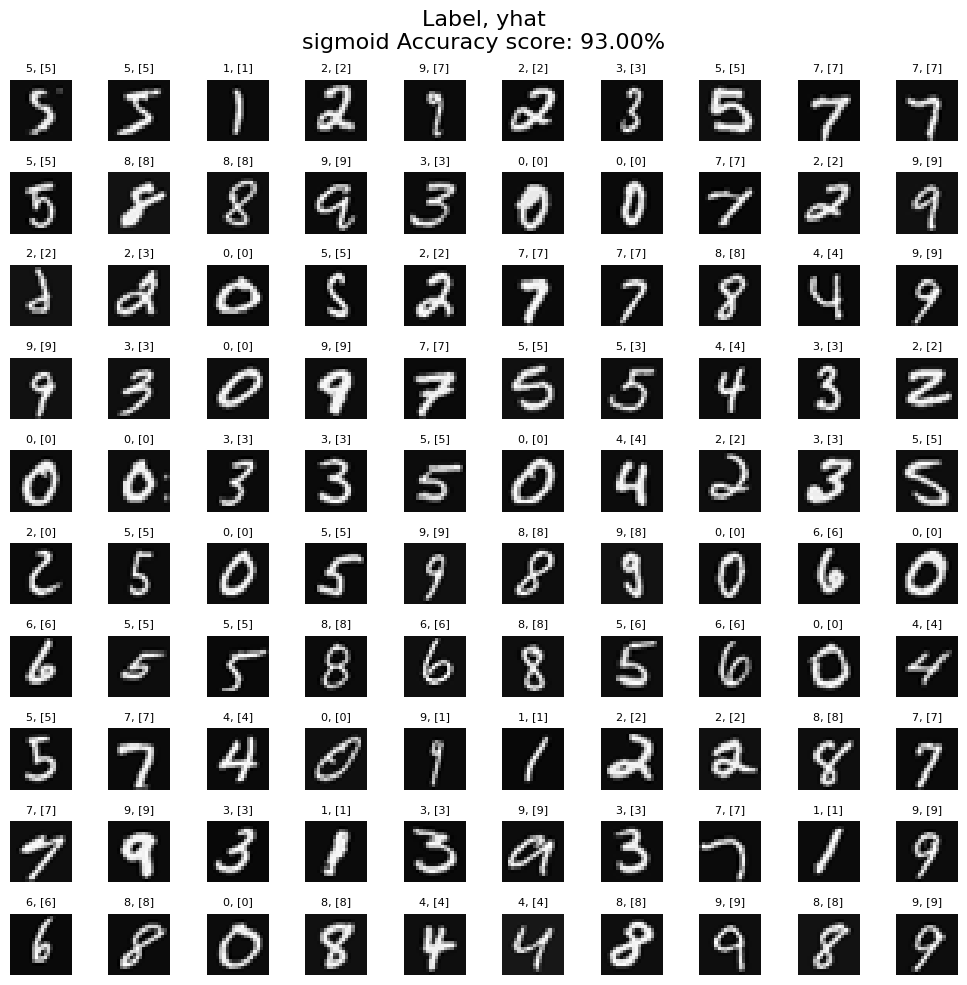

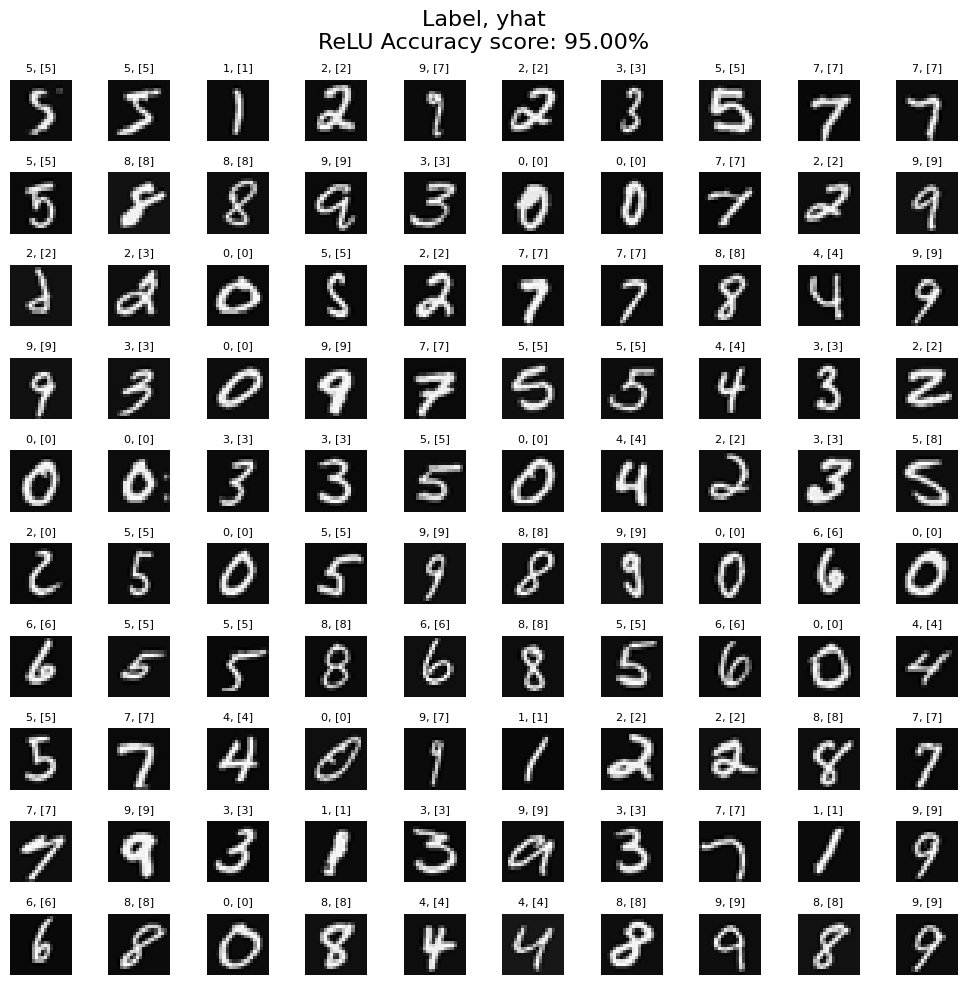

In [14]:
W1 = np.load('/content/W1_sigmoid.npy')
W2 = np.load('/content/W2_sigmoid.npy')
b1 = np.load('/content/b1_sigmoid.npy')
b2 = np.load('/content/b2_sigmoid.npy')
values = range(500, 600)  # Range of indices to test
display_predictions_sigmoid(values, W1, b1, W2, b2)

W1 = np.load('/content/W1_relu.npy')
W2 = np.load('/content/W2_relu.npy')
b1 = np.load('/content/b1_relu.npy')
b2 = np.load('/content/b2_relu.npy')
display_predictions_relu(values, W1, b1, W2, b2)

# **Custom Image testing**

In [44]:
from matplotlib import pyplot as plt
import cv2

# Load the saved model parameters
# W1 = np.load('/content/W1_relu.npy')
# W2 = np.load('/content/W2_relu.npy')
# b1 = np.load('/content/b1_relu.npy')
# b2 = np.load('/content/b2_relu.npy')
W1 = np.load('/content/W1_sigmoid.npy')
W2 = np.load('/content/W2_sigmoid.npy')
b1 = np.load('/content/b1_sigmoid.npy')
b2 = np.load('/content/b2_sigmoid.npy')

def preprocess_image(image):
    # Preprocess the image (resize, convert to grayscale, normalize, etc.)
    image = cv2.resize(image, (20, 20))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = image.astype(np.float32) / 255.0
    image = image.reshape(400, 1)
    return image



def predict_image(image, W1, b1, W2, b2):
    preprocessed_image = preprocess_image(image)
    predictions = forward_prop_relu(W1, b1, W2, b2,preprocessed_image)
    predicted_label = np.argmax(predictions)
    return predicted_label

In [45]:
import numpy as np

def amago_threshold(image):
    threshold = 0.15
    image[image <= threshold] = 0.0
    image[image > threshold] = 1.0
    return image


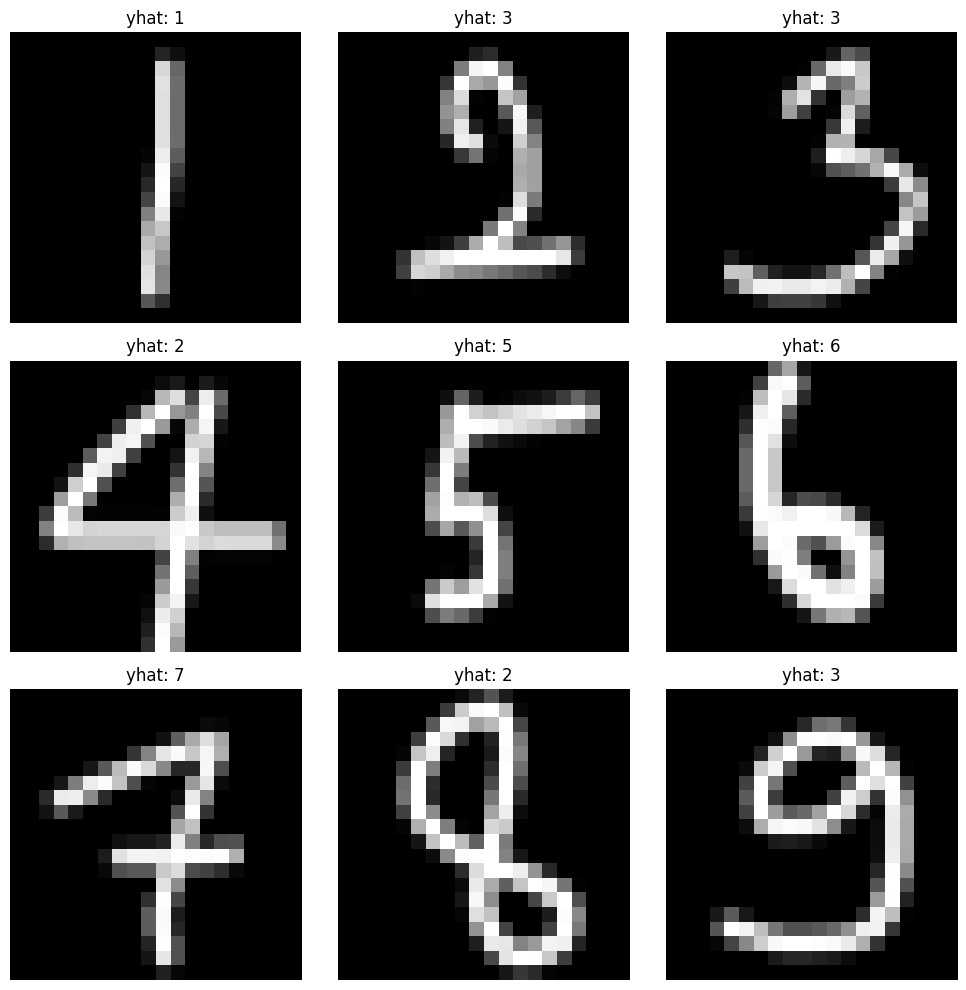

In [49]:
from PIL import Image
import PIL.ImageOps
import numpy as np
import matplotlib.pyplot as plt

# Create a 3x3 grid for the subplots
fig, axes = plt.subplots(3, 3, figsize=(10, 10))

# Loop over images and plot each one in the grid
for i in range(1, 10):
    # Load and preprocess the image for prediction
    image = Image.open(f"/content/{i}.png").convert('L')  # Convert image to grayscale
    image = PIL.ImageOps.invert(image)
    image = image.resize((20, 20))  # Resize the image to 20x20 pixels
    image_array = np.array(image) / 255.0  # Normalize pixel values
    image_array = image_array.flatten().reshape(400, 1)  # Flatten for model input

    # Apply the model to make predictions
    _, _, _, A2 = forward_prop_relu(W1, b1, W2, b2, image_array)
    predictions = get_predictions(A2)
    prediction = predictions[0]

    # Determine the position in the 3x3 grid
    ax = axes[(i - 1) // 3, (i - 1) % 3]
    ax.imshow(image_array.reshape(20, 20) * 255, cmap='gray')  # Display image in grayscale
    ax.set_title(f"yhat: {prediction}")
    ax.axis('off')  # Hide axes for a cleaner look

# Adjust layout and display the grid

plt.tight_layout()
plt.show()
